In [1]:
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [2]:
# use function to pull in the data
df = wrangle_311(spark)
df.show(2, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
-RECORD 1-------------------------

# Exercise 1

How many different cases are there, by department?

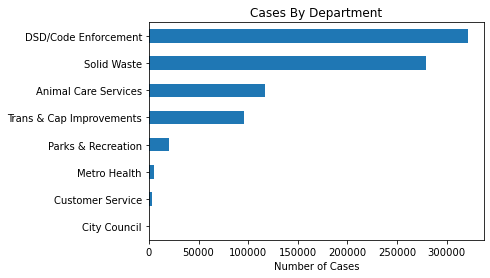

In [9]:
# group by department, get count of observations for each, and plot
df.groupby('department')\
.count()\
.toPandas()\
.set_index('department')['count']\
.sort_values()\
.plot.barh()

plt.gca().set(
    ylabel='', xlabel='Number of Cases', title='Cases By Department');

# Exercise 2

Does the percentage of cases that are late vary by department?

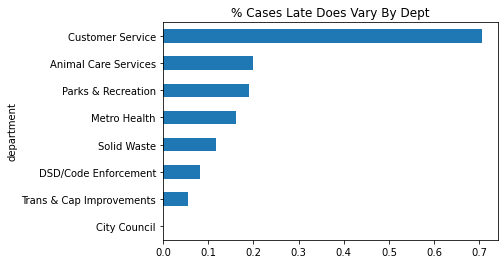

In [16]:
# add a binary column indicating late or not, group by department and get mean cases late from newly made column & plot
df.withColumn('case_late', col('case_late').cast('int'))\
.groupby('department').agg(mean('case_late').alias('pct_cases_late'))\
.toPandas().set_index('department')\
.pct_cases_late.sort_values()\
.plot.barh()
plt.title('% Cases Late Does Vary By Dept');

# Exercise 3

On average, how late are the late cases by department?

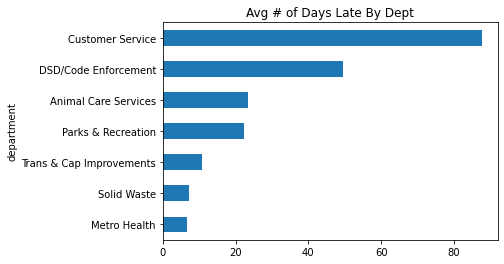

In [22]:
# filter only cases that are late, group by dept, get avg # days late by dept, and plot
df.filter('case_late')\
.groupby('department')\
.agg(mean('num_days_late').alias('avg_num_days_late'))\
.toPandas().set_index('department')\
.avg_num_days_late.sort_values()\
.plot.barh()
plt.title('Avg # of Days Late By Dept');

# Exercise 4

What is the service type that is the most late? Just for Parks & Rec?

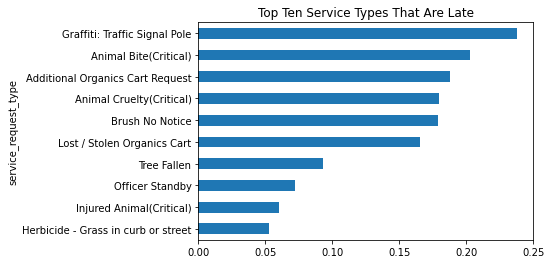

In [33]:
# filter only cases that are late, group by service request type, get avg # days late by service request type, limit to the top 10 and plot
df.filter('case_late')\
.groupby('service_request_type')\
.agg(mean('num_days_late').alias('avg_num_days_late'))\
.toPandas().set_index('service_request_type')\
.avg_num_days_late.sort_values().head(10)\
.plot.barh()
plt.title('Top Ten Service Types That Are Late');

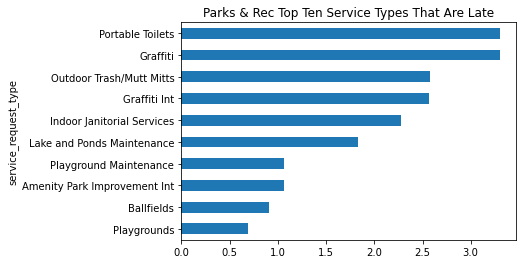

In [38]:
# filter for parks & rec and only cases that are late, group by service request type, get avg # days late by service request type, limit to the top 10 and plot
df.filter('case_late')\
.filter(df.department == 'Parks & Recreation')\
.groupby('service_request_type')\
.agg(mean('num_days_late').alias('avg_num_days_late'))\
.toPandas().set_index('service_request_type')\
.avg_num_days_late.sort_values().head(10)\
.plot.barh()
plt.title('Parks & Rec Top Ten Service Types That Are Late');

# Exercise 5

For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

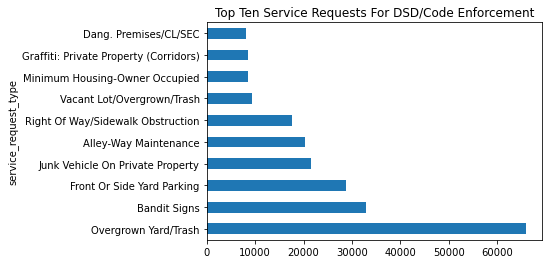

In [42]:
# filter by department, group by service request type and get count for each, sort and limit to top 10, and plot
df.filter(df.department == 'DSD/Code Enforcement')\
.groupby('service_request_type').count()\
.sort(desc('count')).limit(10)\
.toPandas().set_index('service_request_type')['count']\
.plot.barh()
plt.title('Top Ten Service Requests For DSD/Code Enforcement');

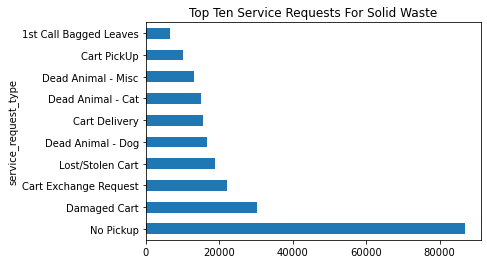

In [44]:
# filter by department, group by service request type and get count for each, sort and limit to top 10, and plot
df.filter(df.department == 'Solid Waste')\
.groupby('service_request_type').count()\
.sort(desc('count')).limit(10)\
.toPandas().set_index('service_request_type')['count']\
.plot.barh()
plt.title('Top Ten Service Requests For Solid Waste');

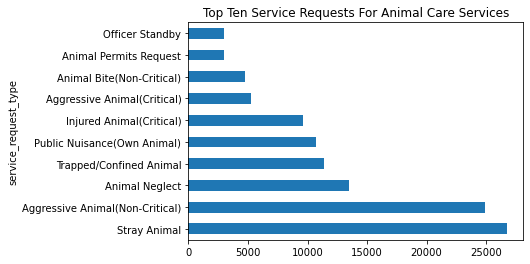

In [45]:
# filter by department, group by service request type and get count for each, sort and limit to top 10, and plot
df.filter(df.department == 'Animal Care Services')\
.groupby('service_request_type').count()\
.sort(desc('count')).limit(10)\
.toPandas().set_index('service_request_type')['count']\
.plot.barh()
plt.title('Top Ten Service Requests For Animal Care Services');

In [39]:
df.groupby(df.department).count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



# Exercise 6

Does whether or not its a weekend matter for when a case is opened/closed?

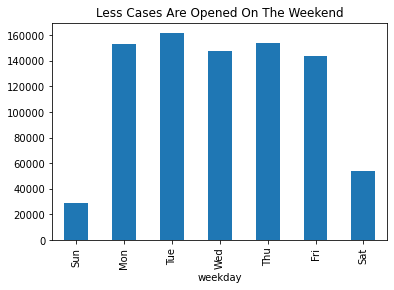

In [53]:
# create a weekday column and group by weekday getting count of cases opened by weekday and plot
df.withColumn('weekday', date_format('case_opened_date', 'E'))\
.groupby('weekday').count().na.drop()\
.toPandas()\
.assign(weekday=lambda df: pd.Categorical(df.weekday, categories=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], ordered=True))\
.set_index('weekday')['count'].sort_index()\
.plot.bar()
plt.title('Less Cases Are Opened On The Weekend');

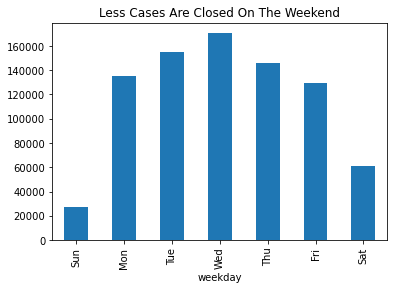

In [55]:
# create a weekday column and group by weekday getting count of cases closed by weekday and plot
df.withColumn('weekday', date_format('case_closed_date', 'E'))\
.groupby('weekday').count().na.drop()\
.toPandas()\
.assign(weekday=lambda df: pd.Categorical(df.weekday, categories=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], ordered=True))\
.set_index('weekday')['count'].sort_index()\
.plot.bar()
plt.title('Less Cases Are Closed On The Weekend');

# Exercise 7

On average, how many cases are opened a day for the Customer Service department?

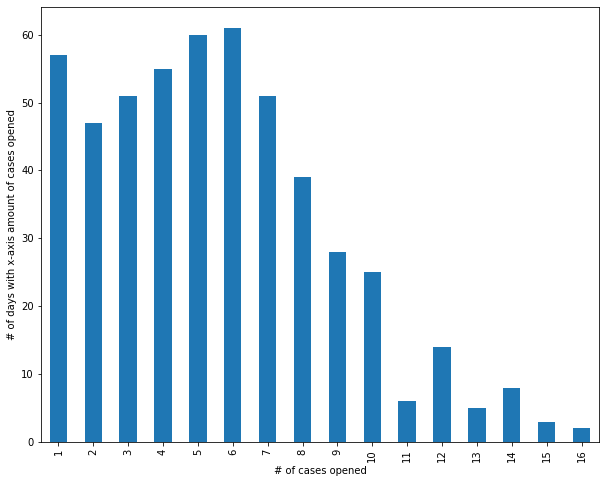

In [60]:
# create a column of day case was opened, filter for only customer service, group by case opened date and get count for those days and plot
df.withColumn('case_opened_date', expr('date(case_opened_date)'))\
.filter(expr('department == "Customer Service"'))\
.groupby('case_opened_date').count()\
.toPandas()['count']\
.value_counts().sort_index()\
.plot.bar(figsize=(10,8))
plt.xlabel('# of cases opened')
plt.ylabel('# of days with x-axis amount of cases opened');

# Exercise 8

Does the number of service requests for the solid waste department vary by day of the week?

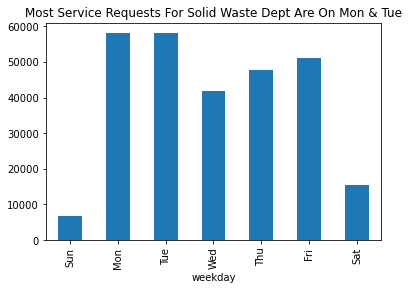

In [63]:
# create a weekday column and group by weekday with count for each after filtering for solid waste dept and plot
df.withColumn('weekday', date_format('case_opened_date', 'E'))\
.filter(expr('department == "Solid Waste"'))\
.groupby('weekday').count().na.drop()\
.toPandas()\
.assign(weekday=lambda df: pd.Categorical(df.weekday, categories=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], ordered=True))\
.set_index('weekday')['count'].sort_index()\
.plot.bar()
plt.title('Most Service Requests For Solid Waste Dept Are On Mon & Tue');